In [1]:
import modeller
import fitter
import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# plt.rcParams['figure.figsize'] = [13, 8.]

In [3]:
p_true = [2, 0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        -p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]),
        p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]) - p[1]*y[1],
        p[1]*y[1]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [9999, 1, 0], dense_output=True) 

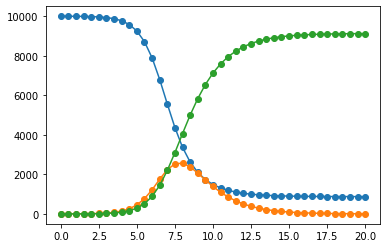

In [4]:
tofsol = np.linspace(0, 20, 41)
plt.figure()
plt.plot(tofsol, sol.sol(tofsol).T, 'o-');

In [5]:
raw_data = sol.sol(tofsol)[2, :]
gendata = sol.sol(tofsol)[1, :]

# # GP 
# randdata = np.random.multivariate_normal(gendata, 8000*np.exp(-1/(2*2**2)*np.abs(tofsol.reshape(1,-1)-tofsol.reshape(-1,1))**2)).reshape(1,-1)
# randdata[randdata < 0] = 0

# Poisson
randdata = np.random.default_rng().poisson(gendata)

# # Negative Binomial
# vdisp = 10**2
# randdata = np.random.default_rng().negative_binomial(n=gendata/(vdisp*(1-1/vdisp)), p=1/vdisp)

data = (np.cumsum(randdata)*p_true[1]*np.gradient(tofsol)).reshape(1, -1)

# randdata = gendata
# data = raw_data.reshape(1,-1)

data_pd = np.array([i for i in data.T])

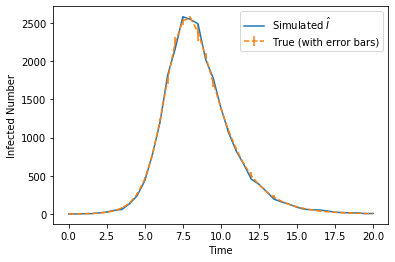

In [6]:
# plt.plot(tofsol, gendata.T)
plt.figure()
plt.plot(tofsol, randdata.T)
plt.errorbar(tofsol, gendata.T, (randdata-gendata).flatten(), linestyle='--')
plt.xlabel('Time')
plt.ylabel("Infected Number")
plt.legend([r'Simulated $\hat{I}$', 'True (with error bars)'])

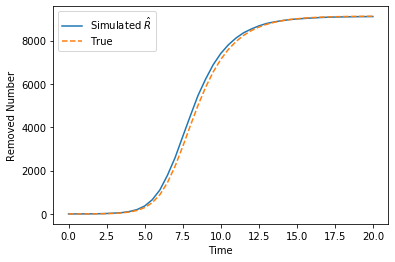

In [7]:
plt.figure()
plt.plot(tofsol, data.T)
plt.plot(tofsol, raw_data.T, '--')
plt.xlabel('Time')
plt.ylabel("Removed Number")
plt.legend([r"Simulated $\hat{R}$", "True"])

In [8]:
def build_config(t,y):
    return {
    "grid_size": 120,
    "basis_number": 60,
    "model_form": {
        "state": 3,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": y, "t": t},
    "observation_vector": [2],
    "weightings":[
        [1]*3,
        [1]*len(t)
    ],
    "regularisation_value": [0]*len(p_true),
}

In [9]:
p0 = np.ones(2)
config=build_config([None], [None])
c0 = [c*np.linspace(1, 0, config['basis_number'])+d 
      for c,d in zip([10000, 1, -10000], [0, 0, 10000])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*3) + [0]*len(config['regularisation_value'])
alpha = 1

testn = 5
# js = list(range(0,len(tofsol),int(len(tofsol)//(testn+1))))[1:-1]
js = [10,11,12,13,14,15,16,17,18,19,20]

fcv_vals = []
fsex = []

for j in js:
    print(f"Running time {j}")
    times_slice = tofsol[0:j]
    data_pd_slice = data_pd[0:j]
    config = build_config(times_slice, data_pd_slice)
    model = modeller.Model(config)
    objective = fitter.Objective()
    objective.make(config, config['dataset'], model)

    solver_setup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }

    ipopt_opts = {
    'ipopt': {
        'print_level': 3,
        'print_frequency_iter': 20,
        
        }
    }
    
    f1ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
    f2ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
    fsex.append((f1ex, f2ex))

    solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)
    x0 = np.hstack([*c0, p0])
    pure_data = solver(x0=x0, p=[1e-14, 1e-14], lbx=lbx, lbg=0);
    x0 = list(np.array(pure_data['x'][:-2]).flatten()) + list(p0)
    prange = np.logspace(-6, 6, num=50)
    solutions = []
    fcv_vals.append(solutions)
    xguess = x0
    for p in prange:
        print(f"Solving p={p}")
        solutions.append(solver(x0=xguess, p=[p, alpha], lbx=lbx, lbg=0))
        xguess = np.array(solutions[-1]['x']).flatten()

Running time 10

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iteratio


Number of Iterations....: 173

                                   (scaled)                 (unscaled)
Objective...............:   3.9418341606366050e-02    3.9418341606366050e-02
Dual infeasibility......:   3.6478357063908201e-09    3.6478357063908201e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596906939e-09    2.5059035596906939e-09
Overall NLP error.......:   3.6478357063908201e-09    3.6478357063908201e-09


Number of objective function evaluations             = 441
Number of objective gradient evaluations             = 174
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 441
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 174
Number of Lagrangian Hessian evaluations             = 173
Total CPU secs in IPOPT (w/o function evaluations)   =      0.268
Total CPU secs in NLP function eval

  nlp_hess_l  | 870.28ms (290.09us) 868.32ms (289.44us)      3000
   nlp_jac_g  |  37.00ms ( 12.33us)  37.13ms ( 12.37us)      3002
       total  |   6.64 s (  6.64 s)   6.62 s (  6.62 s)         1
Solving p=0.000868511373751352
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.0753844140257545e-01    4.0753844140257545e-01
Dual infeasib

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2814

                                   (scaled)                 (unscaled)
Objective...............:   6.4191637693190504e-04    2.2128831514802250e+00
Dual infeasibility......:   4.2228491099854934e-10    1.4557459479993064e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    8.6386201781522337e-06
Overall NLP error.......:   2.5059035596800622e-09    8.6386201781522337e-0


Number of Iterations....: 2663

                                   (scaled)                 (unscaled)
Objective...............:   5.6010899125685949e+00    5.6010899125685949e+00
Dual infeasibility......:   2.0946493198094011e-07    2.0946493198094011e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909150488e-10    9.0909090909150488e-10
Overall NLP error.......:   2.0946493198094011e-07    2.0946493198094011e-07


Number of objective function evaluations             = 5087
Number of objective gradient evaluations             = 2664
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5087
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2664
Number of Lagrangian Hessian evaluations             = 2663
Total CPU secs in IPOPT (w/o function evaluations)   =      4.620
Total CPU secs in NLP functio

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 382

                                   (scaled)                 (unscaled)
Objective...............:   2.5828883973632635e+01    2.5828883973632635e+01
Dual infeasibility......:   4.2678781456606624e-08    4.2678781456606624e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596887397e-09    2.5059035596887397e-09
Overall NLP error.......:   4.2678781456606624e-08    4.2678781456606624e-08


Number of Iterations....: 1015

                                   (scaled)                 (unscaled)
Objective...............:   6.5812532599668316e+01    6.5812532599668316e+01
Dual infeasibility......:   4.2717263464860394e-07    4.2717263464860394e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596843673e-09    2.5059035596843673e-09
Overall NLP error.......:   4.2717263464860394e-07    4.2717263464860394e-07


Number of objective function evaluations             = 1907
Number of objective gradient evaluations             = 1016
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1907
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1016
Number of Lagrangian Hessian evaluations             = 1015
Total CPU secs in IPOPT (w/o function evaluations)   =      1.709
Total CPU secs in NLP functio


Number of Iterations....: 2230

                                   (scaled)                 (unscaled)
Objective...............:   1.2672505089075205e+01    1.2672505089075205e+01
Dual infeasibility......:   1.3156171856857466e-07    1.3156171856857466e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   1.3156171856857466e-07    1.3156171856857466e-07


Number of objective function evaluations             = 4885
Number of objective gradient evaluations             = 2231
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 4885
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2231
Number of Lagrangian Hessian evaluations             = 2230
Total CPU secs in IPOPT (w/o function evaluations)   =      3.296
Total CPU secs in NLP functio

Number of inequality constraint evaluations          = 2785
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1339
Number of Lagrangian Hessian evaluations             = 1337
Total CPU secs in IPOPT (w/o function evaluations)   =      2.336
Total CPU secs in NLP function evaluations           =      0.548

EXIT: Restoration Failed!
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  58.59ms ( 21.04us)  58.83ms ( 21.13us)      2785
       nlp_g  |  23.93ms (  8.59us)  23.73ms (  8.52us)      2785
    nlp_grad  |  51.00us ( 51.00us)  50.80us ( 50.80us)         1
  nlp_grad_f  |  59.55ms ( 44.67us)  59.48ms ( 44.62us)      1333
  nlp_hess_l  | 371.78ms (278.28us) 370.88ms (277.60us)      1336
   nlp_jac_g  |  15.47ms ( 11.54us)  15.53ms ( 11.59us)      1340
       total  |   2.97 s (  2.97 s)   2.96 s (  2.96 s)         1
Solving p=59636.23316594637
Total number of variables.......................


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.3052778138957194e-01    1.2294902101099008e+03
Dual infeasibility......:   3.6201248675942202e+02    3.4099316150930030e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5043882558672095e-04    1.4170398156639568e+00
Overall NLP error.......:   3.6201248675942202e+02    3.4099316150930030e+06


Number of objective function evaluations             = 5653
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5653
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      5.271
Total CPU secs in NLP functio

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 112

                                   (scaled)                 (unscaled)
Objective...............:   8.4748515888254904e-03    8.4748515888254904e-03
Dual infeasibility......:   7.3839934807877423e-11    7.3839934807877423e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of Iterations....: 250

                                   (scaled)                 (unscaled)
Objective...............:   7.6073835896609987e-02    7.6073835896609987e-02
Dual infeasibility......:   9.2360379285901161e-09    9.2360379285901161e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   9.2360379285901161e-09    9.2360379285901161e-09


Number of objective function evaluations             = 616
Number of objective gradient evaluations             = 251
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 616
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 251
Number of Lagrangian Hessian evaluations             = 250
Total CPU secs in IPOPT (w/o function evaluations)   =      0.375
Total CPU secs in NLP function eval

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1038

                                   (scaled)                 (unscaled)
Objective...............:   7.3918906060948131e-01    7.3918906060948131e-01
Dual infeasibility......:   3.1398131798077672e-08    3.1398131798077672e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   3.1398131798077672e-08    3.1398131798077672e-0


Number of Iterations....: 531

                                   (scaled)                 (unscaled)
Objective...............:   2.1139926260219690e+00    2.1139926260219690e+00
Dual infeasibility......:   2.2161888196250735e-07    2.2161888196250735e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   2.2161888196250735e-07    2.2161888196250735e-07


Number of objective function evaluations             = 1277
Number of objective gradient evaluations             = 532
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1277
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 532
Number of Lagrangian Hessian evaluations             = 531
Total CPU secs in IPOPT (w/o function evaluations)   =      0.864
Total CPU secs in NLP function ev

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    3.0865510876736575e-08
Overall NLP error.......:   7.9307849823581906e-09    9.7684417737643811e-08


Number of objective function evaluations             = 4597
Number of objective gradient evaluations             = 2241
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 4597
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2241
Number of Lagrangian Hessian evaluations             = 2240
Total CPU secs in IPOPT (w/o function evaluations)   =      3.929
Total CPU secs in NLP function evaluations           =      0.941

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  99.14ms ( 21.57us)  99.71ms ( 21.69us)      4597
       nlp_g  |  40.78ms (  8.87us)  40.51ms (  8.81us)   


Number of Iterations....: 392

                                   (scaled)                 (unscaled)
Objective...............:   1.8219770321983404e+01    1.8219770321983404e+01
Dual infeasibility......:   5.5351773550545107e-08    5.5351773550545107e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909243122e-10    9.0909090909243122e-10
Overall NLP error.......:   5.5351773550545107e-08    5.5351773550545107e-08


Number of objective function evaluations             = 1268
Number of objective gradient evaluations             = 393
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1268
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 393
Number of Lagrangian Hessian evaluations             = 392
Total CPU secs in IPOPT (w/o function evaluations)   =      0.671
Total CPU secs in NLP function ev

Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 353

                                   (scaled)                 (unscaled)
Objective...............:   6.5665526882716961e+01    6.5665526882716961e+01
Dual infeasibility......:   2.3707028556703379e-07    2.3707028556703379e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596850298e-09    2.5059035596850298e-09
Overall NLP error.......:   2.3707028556703379e-07    2.3707028556703379e-07


Number of objective function evaluations             = 785
Number of objective gradient evaluations             = 354
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 785
Number of equality 


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.4190379242573064e+02    2.4190379242573064e+02
Dual infeasibility......:   1.5583278670205449e-06    1.5583278670205449e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596954126e-09    2.5059035596954126e-09
Overall NLP error.......:   1.5583278670205449e-06    1.5583278670205449e-06


Number of objective function evaluations             = 44035
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 44035
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      4.836
Total CPU secs in NLP funct


                                   (scaled)                 (unscaled)
Objective...............:   3.5546031864674501e+02    3.5546031864674501e+02
Dual infeasibility......:   2.3168661111708307e-06    2.3168661111708307e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596830702e-09    2.5059035596830702e-09
Overall NLP error.......:   2.3168661111708307e-06    2.3168661111708307e-06


Number of objective function evaluations             = 39250
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39250
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      4.685
Total CPU secs in NLP function evaluations           =     


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.8289316705395311e+02    6.8289316705395311e+02
Dual infeasibility......:   1.6562953096988202e-05    1.6562953096988202e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597044731e-09    2.5059035597044731e-09
Overall NLP error.......:   1.6562953096988202e-05    1.6562953096988202e-05


Number of objective function evaluations             = 42623
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42623
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      4.045
Total CPU secs in NLP funct

Complementarity.........:   2.5059035597140345e-09    2.5059035597140345e-09
Overall NLP error.......:   2.5059035597140345e-09    2.5059035597140345e-09


Number of objective function evaluations             = 193
Number of objective gradient evaluations             = 109
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 193
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 109
Number of Lagrangian Hessian evaluations             = 108
Total CPU secs in IPOPT (w/o function evaluations)   =      0.152
Total CPU secs in NLP function evaluations           =      0.041

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.10ms ( 21.26us)   4.13ms ( 21.37us)       193
       nlp_g  |   1.73ms (  8.95us)   1.70ms (  8.79us)       193
    nlp_grad  |  51.00us ( 51.00us)  50.52us ( 50.52us)         1
  nlp_gr


Number of Iterations....: 2435

                                   (scaled)                 (unscaled)
Objective...............:   1.5419507860704050e+03    1.5419507860704050e+03
Dual infeasibility......:   1.7048406095726793e+06    1.7048406095726793e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5117787494414895e-11    2.5117787494414895e-11
Overall NLP error.......:   1.7048406095726793e+06    1.7048406095726793e+06


Number of objective function evaluations             = 6464
Number of objective gradient evaluations             = 2427
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6464
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2441
Number of Lagrangian Hessian evaluations             = 2436
Total CPU secs in IPOPT (w/o function evaluations)   =      4.282
Total CPU secs in NLP functio


Number of Iterations....: 624

                                   (scaled)                 (unscaled)
Objective...............:   6.3660314533198491e-06    9.4091564595637667e-01
Dual infeasibility......:   1.6976268871262803e-10    2.5091357320585366e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.1507121770917211e-11    9.0909090909093197e-06
Overall NLP error.......:   1.6976268871262803e-10    2.5091357320585366e-05


Number of objective function evaluations             = 1980
Number of objective gradient evaluations             = 625
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1980
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 625
Number of Lagrangian Hessian evaluations             = 624
Total CPU secs in IPOPT (w/o function evaluations)   =      1.053
Total CPU secs in NLP function ev


Number of Iterations....: 627

                                   (scaled)                 (unscaled)
Objective...............:   1.6724456079506149e+00    1.6724456079506149e+00
Dual infeasibility......:   9.9593783174014381e-09    9.9593783174014381e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   9.9593783174014381e-09    9.9593783174014381e-09


Number of objective function evaluations             = 1832
Number of objective gradient evaluations             = 628
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1832
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 628
Number of Lagrangian Hessian evaluations             = 627
Total CPU secs in IPOPT (w/o function evaluations)   =      0.989
Total CPU secs in NLP function ev


Number of Iterations....: 523

                                   (scaled)                 (unscaled)
Objective...............:   3.2994841860304884e+00    3.2994841860304884e+00
Dual infeasibility......:   9.0586010420873735e-09    9.0586010420873735e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.0586010420873735e-09    9.0586010420873735e-09


Number of objective function evaluations             = 1137
Number of objective gradient evaluations             = 524
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1137
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 524
Number of Lagrangian Hessian evaluations             = 523
Total CPU secs in IPOPT (w/o function evaluations)   =      0.947
Total CPU secs in NLP function ev

Number of Lagrangian Hessian evaluations             = 355
Total CPU secs in IPOPT (w/o function evaluations)   =      0.582
Total CPU secs in NLP function evaluations           =      0.147

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  15.94ms ( 21.48us)  16.04ms ( 21.62us)       742
       nlp_g  |   6.50ms (  8.76us)   6.43ms (  8.67us)       742
    nlp_grad  |  51.00us ( 51.00us)  51.40us ( 51.40us)         1
  nlp_grad_f  |  16.15ms ( 45.25us)  16.15ms ( 45.22us)       357
  nlp_hess_l  |  99.90ms (281.42us)  99.75ms (281.00us)       355
   nlp_jac_g  |   4.08ms ( 11.43us)   4.10ms ( 11.48us)       357
       total  | 753.80ms (753.80ms) 751.92ms (751.92ms)         1
Solving p=2.329951810515372
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596883617e-09    2.5059035596883617e-09
Overall NLP error.......:   6.0869479069245488e-07    6.0869479069245488e-07


Number of objective function evaluations             = 661
Number of objective gradient evaluations             = 322
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 661
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 322
Number of Lagrangian Hessian evaluations             = 321
Total CPU secs in IPOPT (w/o function evaluations)   =      0.525
Total CPU secs in NLP function evaluations           =      0.135

EXIT: Solved To Acceptable Level.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  14.77ms ( 22.34us)  14.86ms ( 22.49us)       661
       nlp_g  |   6.06ms (  9.17us)   5.99ms (  9.06us)    


Number of Iterations....: 2086

                                   (scaled)                 (unscaled)
Objective...............:   3.9597266470651789e+02    3.9597266470651789e+02
Dual infeasibility......:   6.0708800507887431e-07    6.0708800507887431e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   6.0708800507887431e-07    6.0708800507887431e-07


Number of objective function evaluations             = 17295
Number of objective gradient evaluations             = 2082
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 17295
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2089
Number of Lagrangian Hessian evaluations             = 2087
Total CPU secs in IPOPT (w/o function evaluations)   =      3.058
Total CPU secs in NLP funct

Number of inequality constraint evaluations          = 41173
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      4.200
Total CPU secs in NLP function evaluations           =      2.356

EXIT: Maximum Number of Iterations Exceeded.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 845.81ms ( 20.54us) 850.82ms ( 20.66us)     41173
       nlp_g  | 325.99ms (  7.92us) 324.78ms (  7.89us)     41173
    nlp_grad  |  50.00us ( 50.00us)  50.14us ( 50.14us)         1
  nlp_grad_f  | 135.92ms ( 45.28us) 135.93ms ( 45.28us)      3002
  nlp_hess_l  | 845.34ms (281.78us) 843.67ms (281.22us)      3000
   nlp_jac_g  |  34.67ms ( 11.55us)  34.81ms ( 11.60us)      3002
       total  |   6.91 s (  6.91 s)   6.89 s (  6.89 s)         1
Solving p=33932.217718953296
Total number of variables..


Number of Iterations....: 700

                                   (scaled)                 (unscaled)
Objective...............:   1.4047676730772974e+01    1.6654804759742708e+03
Dual infeasibility......:   2.3953706467403274e-07    2.8399308450261857e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090910632950e-10    1.0778103660981530e-07
Overall NLP error.......:   2.3953706467403274e-07    2.8399308450261857e-05


Number of objective function evaluations             = 1551
Number of objective gradient evaluations             = 701
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1551
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 701
Number of Lagrangian Hessian evaluations             = 700
Total CPU secs in IPOPT (w/o function evaluations)   =      1.169
Total CPU secs in NLP function ev

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 194

                                   (scaled)                 (unscaled)
Objective...............:   6.9441482468773727e-02    6.9441482468773727e-02
Dual infeasibility......:   5.7847450696368080e-08    5.7847450696368080e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035655344847e-09    2.5059035655344847e-09
Overall NLP error.......:   5.7847450696368080e-08    5.7847450696368080e-08


Number of Iterations....: 208

                                   (scaled)                 (unscaled)
Objective...............:   4.3686337370339661e-05    3.8469580840733281e-01
Dual infeasibility......:   1.7436819038499849e-10    1.5354620231043455e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.2066638077479080e-05
Overall NLP error.......:   2.5059035596800622e-09    2.2066638077479080e-05


Number of objective function evaluations             = 455
Number of objective gradient evaluations             = 209
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 455
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 209
Number of Lagrangian Hessian evaluations             = 208
Total CPU secs in IPOPT (w/o function evaluations)   =      0.344
Total CPU secs in NLP function eval

Overall NLP error.......:   3.2333486757204016e-08    3.2333486757204016e-08


Number of objective function evaluations             = 4644
Number of objective gradient evaluations             = 525
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 4644
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 560
Number of Lagrangian Hessian evaluations             = 524
Total CPU secs in IPOPT (w/o function evaluations)   =      1.022
Total CPU secs in NLP function evaluations           =      0.348

EXIT: Solved To Acceptable Level.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 107.15ms ( 23.07us) 107.88ms ( 23.23us)      4644
       nlp_g  |  41.33ms (  8.90us)  41.32ms (  8.90us)      4644
    nlp_grad  |  55.00us ( 55.00us)  54.32us ( 54.32us)         1
  nlp_grad_f  |  26.23ms ( 49.87us)  26.28ms ( 49.95us)       526
  nlp_hess_l 


Number of Iterations....: 542

                                   (scaled)                 (unscaled)
Objective...............:   2.6816053110007085e+00    2.6816053110007085e+00
Dual infeasibility......:   4.0917021043180322e-09    4.0917021043180322e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909092492e-10    9.0909090909092492e-10
Overall NLP error.......:   4.0917021043180322e-09    4.0917021043180322e-09


Number of objective function evaluations             = 1657
Number of objective gradient evaluations             = 540
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1657
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 544
Number of Lagrangian Hessian evaluations             = 542
Total CPU secs in IPOPT (w/o function evaluations)   =      0.825
Total CPU secs in NLP function ev


                                   (scaled)                 (unscaled)
Objective...............:   1.0206187666365343e+01    1.0206187666365343e+01
Dual infeasibility......:   4.0627024645345123e-08    4.0627024645345123e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   4.0627024645345123e-08    4.0627024645345123e-08


Number of objective function evaluations             = 1121
Number of objective gradient evaluations             = 506
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1121
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 506
Number of Lagrangian Hessian evaluations             = 505
Total CPU secs in IPOPT (w/o function evaluations)   =      0.774
Total CPU secs in NLP function evaluations           =      0.21


                                   (scaled)                 (unscaled)
Objective...............:   5.9553207752234840e+00    5.9553207752234840e+00
Dual infeasibility......:   4.4485945018597208e-09    4.4485945018597208e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036818289609e-09    2.5059036818289609e-09
Overall NLP error.......:   4.4485945018597208e-09    4.4485945018597208e-09


Number of objective function evaluations             = 301
Number of objective gradient evaluations             = 177
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 301
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 177
Number of Lagrangian Hessian evaluations             = 176
Total CPU secs in IPOPT (w/o function evaluations)   =      0.186
Total CPU secs in NLP function evaluations           =      0.069



                                   (scaled)                 (unscaled)
Objective...............:   9.4826409858201721e+00    9.4826409858201721e+00
Dual infeasibility......:   3.1424319847355246e-09    3.1424319847355246e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035708299527e-09    2.5059035708299527e-09
Overall NLP error.......:   3.1424319847355246e-09    3.1424319847355246e-09


Number of objective function evaluations             = 2174
Number of objective gradient evaluations             = 1188
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 2174
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1188
Number of Lagrangian Hessian evaluations             = 1187
Total CPU secs in IPOPT (w/o function evaluations)   =      1.338
Total CPU secs in NLP function evaluations           =      0


EXIT: Solved To Acceptable Level.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  39.97ms ( 21.68us)  40.18ms ( 21.79us)      1844
       nlp_g  |  16.32ms (  8.85us)  16.12ms (  8.74us)      1844
    nlp_grad  |  53.00us ( 53.00us)  52.44us ( 52.44us)         1
  nlp_grad_f  |  44.65ms ( 45.37us)  44.62ms ( 45.35us)       984
  nlp_hess_l  | 276.31ms (281.37us) 275.74ms (280.79us)       982
   nlp_jac_g  |  11.58ms ( 11.77us)  11.60ms ( 11.79us)       984
       total  |   1.62 s (  1.62 s)   1.62 s (  1.62 s)         1
Solving p=372.7593720314938
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constr

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 776

                                   (scaled)                 (unscaled)
Objective...............:   1.7108835028691544e+02    1.7108835028691544e+02
Dual infeasibility......:   4.7684209221656371e-07    4.7684209221656371e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   4.7684209221656371e-07    4.7684209221656371e-07


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.2953560750314243e+03    1.2953560750314243e+03
Dual infeasibility......:   1.0532479097780952e-05    1.0532479097780952e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596805581e-09    2.5059035596805581e-09
Overall NLP error.......:   1.0532479097780952e-05    1.0532479097780952e-05


Number of objective function evaluations             = 26175
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 26175
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      3.488
Total CPU secs in NLP funct

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............:   4.2789528420340295e-08    1.0255795620569012e-07
Dual infeasibility......:   5.5870522093645505e-09    1.3391048627087367e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9842617254542143e-09    7.1526795139897566e-09
Overall NLP e


Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   3.3057745625257498e-04    5.3478572263428692e+00
Dual infeasibility......:   5.3205925189184768e-09    8.6072926669821415e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   8.6163189904493699e-10    1.3938894775191143e-05
Overall NLP error.......:   5.3205925189184768e-09    8.6072926669821415e-05


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.036
Total CPU secs in NLP function evaluation

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 809

                                   (scaled)                 (unscaled)
Objective...............:   2.4339607813492788e+02    2.4339607813492788e+02
Dual infeasibility......:   1.3491030626752502e+06    1.3491030626752502e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.3938535321421518e-11    1.3938535321421518e-11
Overall NLP error.......:   1.3491030626752502e+06    1.3491030626752502e+06


Number of Iterations....: 188

                                   (scaled)                 (unscaled)
Objective...............:   1.1647836036039405e+00    1.1647836036039405e+00
Dual infeasibility......:   6.0443700484262698e-09    6.0443700484262698e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   6.0443700484262698e-09    6.0443700484262698e-09


Number of objective function evaluations             = 463
Number of objective gradient evaluations             = 189
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 463
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 189
Number of Lagrangian Hessian evaluations             = 188
Total CPU secs in IPOPT (w/o function evaluations)   =      0.279
Total CPU secs in NLP function eval

Number of inequality constraint Jacobian evaluations = 1140
Number of Lagrangian Hessian evaluations             = 1139
Total CPU secs in IPOPT (w/o function evaluations)   =      1.695
Total CPU secs in NLP function evaluations           =      0.449

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  57.29ms ( 20.39us)  57.96ms ( 20.63us)      2809
       nlp_g  |  23.07ms (  8.21us)  22.91ms (  8.16us)      2809
    nlp_grad  |  51.00us ( 51.00us)  50.12us ( 50.12us)         1
  nlp_grad_f  |  47.50ms ( 41.63us)  47.60ms ( 41.71us)      1141
  nlp_hess_l  | 291.65ms (256.06us) 291.79ms (256.18us)      1139
   nlp_jac_g  |  11.91ms ( 10.44us)  11.99ms ( 10.51us)      1141
       total  |   2.22 s (  2.22 s)   2.22 s (  2.22 s)         1
Solving p=0.025595479226995333
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 175

                                   (scaled)                 (unscaled)
Objective...............:   4.8490165253464568e+00    4.8490165253464568e+00
Dual infeasibility......:   2.4818389537728132e-09    2.4818389537728132e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036524042680e-09    2.5059036524042680e-09
Overall NLP error.......:   2.5059036524042680e-09    2.5059036524042680e-09

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 481

                                   (scaled)                 (unscaled)
Objective...............:   1.1353416836369677e+01    1.1353416836369677e+01
Dual infeasibility......:   2.7114740808490698e-09    2.7114740808490698e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035617168584e-09    2.5059035617168584e-09
Overall NLP error.......:   2.7114740808490698e-09    2.7114740808490698e-09


Number of Iterations....: 1075

                                   (scaled)                 (unscaled)
Objective...............:   3.1748465651197154e+01    3.1748465651197154e+01
Dual infeasibility......:   3.8156760507217661e-08    3.8156760507217661e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   3.8156760507217661e-08    3.8156760507217661e-08


Number of objective function evaluations             = 1831
Number of objective gradient evaluations             = 1076
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1831
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1076
Number of Lagrangian Hessian evaluations             = 1075
Total CPU secs in IPOPT (w/o function evaluations)   =      1.067
Total CPU secs in NLP functio

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 325

                                   (scaled)                 (unscaled)
Objective...............:   2.8948948296557359e+02    2.8948948296557359e+02
Dual infeasibility......:   5.1582202022601882e-07    5.1582202022601882e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   5.1582202022601882e-07    5.1582202022601882e-07

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.7279421897082236e+03    1.7279421897082236e+03
Dual infeasibility......:   1.5746425647950817e-05    1.5746425647950817e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596823899e-09    2.5059035596823899e-09
Overall NLP error.......:   1.5746425647950817e-05    1.5746425647950817e-0


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   9.1378810712748291e+03    9.1378810712748291e+03
Dual infeasibility......:   3.0405848491087524e-04    3.0405848491087524e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625298552e-06    1.8449144625298552e-06
Overall NLP error.......:   3.0405848491087524e-04    3.0405848491087524e-04


Number of objective function evaluations             = 42182
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42182
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      4.613
Total CPU secs in NLP funct

Number of objective gradient evaluations             = 2457
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8367
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2471
Number of Lagrangian Hessian evaluations             = 2466
Total CPU secs in IPOPT (w/o function evaluations)   =      4.415
Total CPU secs in NLP function evaluations           =      1.059

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 170.05ms ( 20.32us) 171.01ms ( 20.44us)      8367
       nlp_g  |  66.82ms (  7.99us)  66.52ms (  7.95us)      8367
    nlp_grad  |  52.00us ( 52.00us)  51.29us ( 51.29us)         1
  nlp_grad_f  | 103.01ms ( 41.91us) 103.00ms ( 41.90us)      2458
  nlp_hess_l  | 638.05ms (259.16us) 636.91ms (258.70us)      2462
   nlp_jac_g  |  26.10ms ( 10.56us)  26


Number of Iterations....: 991

                                   (scaled)                 (unscaled)
Objective...............:   7.3740634894966339e-01    7.3740634894966339e-01
Dual infeasibility......:   3.1631006555348810e-08    3.1631006555348810e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.1631006555348810e-08    3.1631006555348810e-08


Number of objective function evaluations             = 3396
Number of objective gradient evaluations             = 993
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3396
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 993
Number of Lagrangian Hessian evaluations             = 992
Total CPU secs in IPOPT (w/o function evaluations)   =      1.595
Total CPU secs in NLP function ev


                                   (scaled)                 (unscaled)
Objective...............:   2.5897554962739999e+00    2.5897554962739999e+00
Dual infeasibility......:   9.8993215277258306e-08    9.8993215277258306e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.8993215277258306e-08    9.8993215277258306e-08


Number of objective function evaluations             = 1237
Number of objective gradient evaluations             = 322
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1237
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 326
Number of Lagrangian Hessian evaluations             = 323
Total CPU secs in IPOPT (w/o function evaluations)   =      0.492
Total CPU secs in NLP function evaluations           =      0.14


Number of Iterations....: 1727

                                   (scaled)                 (unscaled)
Objective...............:   3.3722628833146624e+00    3.3722628833146624e+00
Dual infeasibility......:   2.7735444400157845e-10    2.7735444400157845e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5064464871523952e-09    2.5064464871523952e-09
Overall NLP error.......:   2.5064464871523952e-09    2.5064464871523952e-09


Number of objective function evaluations             = 3957
Number of objective gradient evaluations             = 1728
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3957
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1728
Number of Lagrangian Hessian evaluations             = 1727
Total CPU secs in IPOPT (w/o function evaluations)   =      2.849
Total CPU secs in NLP functio

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 91

                                   (scaled)                 (unscaled)
Objective...............:   1.4560404009563399e+01    1.4560404009563399e+01
Dual infeasibility......:   2.3406067161751922e-11    2.3406067161751922e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035630832288e-09    2.5059035630832288e-09
Overall NLP error.......:   2.5059035630832288e-09    2.5059035630832288e-09


                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1291

                                   (scaled)                 (unscaled)
Objective...............:   2.3085061082340822e+01    2.3085061082340822e+01
Dual infeasibility......:   2.4166055815913000e-10    2.4166055815913000e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597017653e-09    2.5059035597017653e-09
Overall NLP error.......:   2.5059035597017653e-09    2.5059035597017653e-0


Number of Iterations....: 1155

                                   (scaled)                 (unscaled)
Objective...............:   2.9172449388328960e+01    2.9172449388328960e+01
Dual infeasibility......:   2.5060043633036219e-09    2.5060043633036219e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596809092e-09    2.5059035596809092e-09
Overall NLP error.......:   2.5060043633036219e-09    2.5060043633036219e-09


Number of objective function evaluations             = 1907
Number of objective gradient evaluations             = 1156
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1907
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1156
Number of Lagrangian Hessian evaluations             = 1155
Total CPU secs in IPOPT (w/o function evaluations)   =      1.151
Total CPU secs in NLP functio

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1124

                                   (scaled)                 (unscaled)
Objective...............:   3.9787628022754504e+01    3.9787628022754504e+01
Dual infeasibility......:   4.0426948529667462e-08    4.0426948529667462e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909188290e-10    9.0909090909188290e-10
Overall NLP error.......:   4.0426948529667462e-08    4.0426948529667462e-08


Number of objective function evaluations             = 1864
Number of objective gradient evaluations             = 1125
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1864
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1125
Number of Lagrangian Hessi

Complementarity.........:   2.5059035596833080e-09    2.5059035596833080e-09
Overall NLP error.......:   6.0714910837608901e-07    6.0714910837608901e-07


Number of objective function evaluations             = 3022
Number of objective gradient evaluations             = 662
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3022
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 662
Number of Lagrangian Hessian evaluations             = 661
Total CPU secs in IPOPT (w/o function evaluations)   =      0.791
Total CPU secs in NLP function evaluations           =      0.303

EXIT: Solved To Acceptable Level.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  60.88ms ( 20.15us)  61.28ms ( 20.28us)      3022
       nlp_g  |  23.91ms (  7.91us)  23.76ms (  7.86us)      3022
    nlp_grad  |  55.00us ( 55.00us)  54.23us ( 54.23us)         1
  


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.3894104105564725e+03    3.3894104105564725e+03
Dual infeasibility......:   4.3467649847917430e-05    4.3467649847917430e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596822596e-09    2.5059035596822596e-09
Overall NLP error.......:   4.3467649847917430e-05    4.3467649847917430e-05


Number of objective function evaluations             = 29243
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 29243
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      3.577
Total CPU secs in NLP funct

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   3.9466393417135490e-08    8.2768931966744543e-08
Dual infeasibility......:   2.1737505871783763e-10    4.5587903754266265e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5111303403879217e-09    5.2663432938099329e-09
Overall NLP e

Solving p=2.94705170255181e-05
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 896

                                   (scaled)                 (unscaled)
Objective...............:   5.1184773180003851e-01    5.1184773180003851e-01
Dual infeasibility......:   6.8481293218821612e-08    6.8481293218821612e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.09


Number of Iterations....: 2416

                                   (scaled)                 (unscaled)
Objective...............:   1.3241980901007238e+00    1.3241980901007238e+00
Dual infeasibility......:   5.6427750147622464e-10    5.6427750147622464e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective function evaluations             = 6311
Number of objective gradient evaluations             = 2415
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6311
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2418
Number of Lagrangian Hessian evaluations             = 2416
Total CPU secs in IPOPT (w/o function evaluations)   =      4.127
Total CPU secs in NLP functio


Number of Iterations....: 186

                                   (scaled)                 (unscaled)
Objective...............:   4.6520154115961834e+00    4.6520154115961834e+00
Dual infeasibility......:   9.2515270614931763e-10    9.2515270614931763e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909296923790693e-10    9.0909296923790693e-10
Overall NLP error.......:   9.2515270614931763e-10    9.2515270614931763e-10


Number of objective function evaluations             = 293
Number of objective gradient evaluations             = 187
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 293
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 187
Number of Lagrangian Hessian evaluations             = 186
Total CPU secs in IPOPT (w/o function evaluations)   =      0.195
Total CPU secs in NLP function eval


Number of Iterations....: 369

                                   (scaled)                 (unscaled)
Objective...............:   2.2739358598497976e+01    2.2739358598497976e+01
Dual infeasibility......:   9.9407318791256159e-09    9.9407318791256159e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597267247e-09    2.5059035597267247e-09
Overall NLP error.......:   9.9407318791256159e-09    9.9407318791256159e-09


Number of objective function evaluations             = 607
Number of objective gradient evaluations             = 370
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 607
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 370
Number of Lagrangian Hessian evaluations             = 369
Total CPU secs in IPOPT (w/o function evaluations)   =      0.376
Total CPU secs in NLP function eval


Number of Iterations....: 732

                                   (scaled)                 (unscaled)
Objective...............:   3.5738831972767088e+01    3.5738831972767088e+01
Dual infeasibility......:   4.1254083732940132e-09    4.1254083732940132e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   4.1254083732940132e-09    4.1254083732940132e-09


Number of objective function evaluations             = 1178
Number of objective gradient evaluations             = 733
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1178
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 733
Number of Lagrangian Hessian evaluations             = 732
Total CPU secs in IPOPT (w/o function evaluations)   =      0.742
Total CPU secs in NLP function ev


Number of Iterations....: 441

                                   (scaled)                 (unscaled)
Objective...............:   6.2928856724984499e+01    6.2928856724984499e+01
Dual infeasibility......:   2.5128052662315749e-07    2.5128052662315749e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   2.5128052662315749e-07    2.5128052662315749e-07


Number of objective function evaluations             = 708
Number of objective gradient evaluations             = 442
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 708
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 442
Number of Lagrangian Hessian evaluations             = 441
Total CPU secs in IPOPT (w/o function evaluations)   =      0.455
Total CPU secs in NLP function eval

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596801544e-09    2.5059035596801544e-09
Overall NLP error.......:   2.8275500577074104e-06    2.8275500577074104e-06


Number of objective function evaluations             = 24358
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 24358
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      3.684
Total CPU secs in NLP function evaluations           =      1.704

EXIT: Maximum Number of Iterations Exceeded.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 489.32ms ( 20.09us) 491.86ms ( 20.19us)     24358
       nlp_g  | 188.38ms (  7.73us) 187.7


                                   (scaled)                 (unscaled)
Objective...............:   2.1804740914189780e+00    6.2042696225547996e+04
Dual infeasibility......:   1.1153721036644656e+02    3.1736535131711387e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042419465660257e-04    4.2801346050293478e+00
Overall NLP error.......:   1.1153721036644656e+02    3.1736535131711387e+06


Number of objective function evaluations             = 6726
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6726
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      5.081
Total CPU secs in NLP function evaluations           =      1

        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 363

                                   (scaled)                 (unscaled)
Objective...............:   3.8237609845884705e+01    3.8237609845884705e+01
Dual infeasibility......:   4.5443179056127483e+04    4.5443179056127483e+04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2096435736892338e-11    3.2096435736892338e-11
Overall NLP error.......:   4.5443179056127483e+04    4.5443179056127483e+04


Number of objective function evaluations             = 1010
Number of objective gradient evaluations             = 361
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1010
Number of equality constraint Jacobian evaluations   = 0
Number of inequality con


Number of Iterations....: 351

                                   (scaled)                 (unscaled)
Objective...............:   2.2565012407201144e-04    6.7228645924798591e-01
Dual infeasibility......:   7.3513530384413801e-10    2.1902115610264301e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035601626207e-09    7.4659167089180025e-06
Overall NLP error.......:   2.5059035601626207e-09    7.4659167089180025e-06


Number of objective function evaluations             = 833
Number of objective gradient evaluations             = 350
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 833
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 353
Number of Lagrangian Hessian evaluations             = 351
Total CPU secs in IPOPT (w/o function evaluations)   =      0.607
Total CPU secs in NLP function eval


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.99ms ( 20.55us)   4.02ms ( 20.71us)       194
       nlp_g  |   1.60ms (  8.23us)   1.59ms (  8.19us)       194
    nlp_grad  |  51.00us ( 51.00us)  50.62us ( 50.62us)         1
  nlp_grad_f  |   4.24ms ( 41.14us)   4.24ms ( 41.14us)       103
  nlp_hess_l  |  25.68ms (254.26us)  25.68ms (254.30us)       101
   nlp_jac_g  |   1.08ms ( 10.49us)   1.09ms ( 10.55us)       103
       total  | 186.64ms (186.64ms) 186.03ms (186.03ms)         1
Solving p=0.000868511373751352
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constra


Number of Iterations....: 273

                                   (scaled)                 (unscaled)
Objective...............:   1.3046433252501402e+01    1.3046433252501402e+01
Dual infeasibility......:   1.6171032082643287e-11    1.6171032082643287e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035840980492e-09    2.5059035840980492e-09
Overall NLP error.......:   2.5059035840980492e-09    2.5059035840980492e-09


Number of objective function evaluations             = 451
Number of objective gradient evaluations             = 274
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 451
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 274
Number of Lagrangian Hessian evaluations             = 273
Total CPU secs in IPOPT (w/o function evaluations)   =      0.287
Total CPU secs in NLP function eval

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 114

                                   (scaled)                 (unscaled)
Objective...............:   3.5781830691120881e+01    3.5781830691120881e+01
Dual infeasibility......:   1.2025279387798188e-09    1.2025279387798188e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597081681e-09    2.5059035597081681e-09
Overall NLP error.......:   2.5059035597081681e-09    2.5059035597081681e-09


Number of Iterations....: 235

                                   (scaled)                 (unscaled)
Objective...............:   4.1227904608029156e+01    4.1227904608029156e+01
Dual infeasibility......:   3.1838709947937637e-09    3.1838709947937637e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909093951007949e-10    9.0909093951007949e-10
Overall NLP error.......:   3.1838709947937637e-09    3.1838709947937637e-09


Number of objective function evaluations             = 368
Number of objective gradient evaluations             = 236
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 368
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 236
Number of Lagrangian Hessian evaluations             = 235
Total CPU secs in IPOPT (w/o function evaluations)   =      0.240
Total CPU secs in NLP function eval

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 288

                                   (scaled)                 (unscaled)
Objective...............:   1.0913567703663387e+02    1.0913567703663387e+02
Dual infeasibility......:   5.4338877840280695e-07    5.4338877840280695e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596801689e-09    2.5059035596801689e-09
Overall NLP error.......:   5.4338877840280695e-07    5.4338877840280695e-07

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.6594234750940927e+02    6.6594234750940927e+02
Dual infeasibility......:   1.5182066552239028e-06    1.5182066552239028e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596850790e-09    2.5059035596850790e-09
Overall NLP error.......:   1.5182066552239028e-06    1.5182066552239028e-0

Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3001
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      4.590
Total CPU secs in NLP function evaluations           =      1.254

EXIT: Maximum Number of Iterations Exceeded.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 190.87ms ( 20.37us) 192.02ms ( 20.49us)      9370
       nlp_g  |  74.78ms (  7.98us)  74.33ms (  7.93us)      9370
    nlp_grad  | 118.00us (118.00us)  62.57us ( 62.57us)         1
  nlp_grad_f  | 125.56ms ( 41.83us) 125.49ms ( 41.80us)      3002
  nlp_hess_l  | 770.40ms (256.80us) 769.23ms (256.41us)      3000
   nlp_jac_g  |  31.21ms ( 10.40us)  31.27ms ( 10.42us)      3002
       total  |   6.03 s (  6.03 s)   6.02 s (  6.02 s)         1
Solving p=184206.99693267164
Total number of variables............................:      182
                     var

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   3.5521379719371347e-08    6.6218176063148802e-08
Dual infeasibility......:   9.2737066674677624e-09    1.7287840329284519e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7912683339094721e-09    5.2034211349485436e-09
Overall NLP e


Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   1.6419316784133353e-04    8.3096332391273222e+00
Dual infeasibility......:   9.2105622987329446e-09    4.6613629321388348e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.1867418155205950e-10    1.1066856626579587e-05
Overall NLP error.......:   9.2105622987329446e-09    4.6613629321388348e-04


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w/o function evaluations)   =      0.045
Total CPU secs in NLP function evaluation

                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 263

                                   (scaled)                 (unscaled)
Objective...............:   2.1390044808124893e+00    2.1390044808124893e+00
Dual infeasibility......:   1.1565437757053598e-11    1.1565437757053598e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036674835923e-09    2.5059036674835923e-09
Overall NLP error.......:   2.5059036674835923e-09    2.5059036674835923e-09


Number of objective function evaluations             = 479
Nu

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 218

                                   (scaled)                 (unscaled)
Objective...............:   9.6453307253527445e+00    9.6453307253527445e+00
Dual infeasibility......:   4.1907373562642478e-11    4.1907373562642478e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036218469981e-09    2.5059036218469981e-09
Overall NLP error.......:   2.5059036218469981e-09    2.5059036218469981e-09

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   2.5702859367110488e+01    2.5702859367110488e+01
Dual infeasibility......:   2.3403665136311912e-10    2.3403665136311912e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035665886490e-09    2.5059035665886490e-09
Overall NLP error.......:   2.5059035665886490e-09    2.5059035665886490e-09



Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   3.6604422761764170e+01    3.6604422761764170e+01
Dual infeasibility......:   3.6047696277419867e-09    3.6047696277419867e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596814924e-09    2.5059035596814924e-09
Overall NLP error.......:   3.6047696277419867e-09    3.6047696277419867e-09


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 47
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 37
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPOPT (w/o function evaluations)   =      0.039
Total CPU secs in NLP function evaluation

    nlp_grad  |  51.00us ( 51.00us)  50.96us ( 50.96us)         1
  nlp_grad_f  |   2.90ms ( 42.03us)   2.90ms ( 42.04us)        69
  nlp_hess_l  |  17.31ms (258.30us)  17.29ms (258.03us)        67
   nlp_jac_g  | 720.00us ( 10.43us) 720.29us ( 10.44us)        69
       total  |  99.14ms ( 99.14ms)  98.89ms ( 98.89ms)         1
Solving p=68.66488450042998
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 74

                                  

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 963

                                   (scaled)                 (unscaled)
Objective...............:   2.5860199775489974e+02    2.5860199775489974e+02
Dual infeasibility......:   1.9543624299718980e+04    1.9543624299718980e+04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090508286031e-12    9.0909090508286031e-12
Overall NLP error.......:   1.9543624299718980e+04    1.9543624299718980e+04


Number of objective function evaluations             = 6290
Number of objective gradient evaluations             = 964
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6290
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 966
Number of Lagrangian Hessian 

  nlp_grad_f  | 126.32ms ( 42.08us) 126.20ms ( 42.04us)      3002
  nlp_hess_l  | 778.20ms (259.40us) 777.01ms (259.00us)      3000
   nlp_jac_g  |  31.74ms ( 10.57us)  31.82ms ( 10.60us)      3002
       total  |   6.52 s (  6.52 s)   6.50 s (  6.50 s)         1
Solving p=184206.99693267164
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 153

                                   (scaled)                 (unscaled)
Objective...............:  

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   3.4063940200807286e-08    6.0159078299729088e-08
Dual infeasibility......:   1.6390790585874833e-09    2.8947175471695370e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5389402076082654e-09    4.4839293941754942e-09
Overall NLP e

    nlp_grad  |  50.00us ( 50.00us)  49.50us ( 49.50us)         1
  nlp_grad_f  | 126.42ms ( 42.24us) 126.31ms ( 42.20us)      2993
  nlp_hess_l  | 776.68ms (259.15us) 775.51ms (258.76us)      2997
   nlp_jac_g  |  31.56ms ( 10.50us)  31.62ms ( 10.52us)      3005
       total  |   6.77 s (  6.77 s)   6.76 s (  6.76 s)         1
Solving p=5.428675439323859e-06
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 319

                             

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 269

                                   (scaled)                 (unscaled)
Objective...............:   1.6027039127183857e+00    1.6027039127183857e+00
Dual infeasibility......:   4.7749151206604099e-09    4.7749151206604099e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   4.7749151206604099e-09    4.7749151206604099e-09

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   4.0335848476469218e+00    4.0335848476469218e+00
Dual infeasibility......:   1.5670414122595976e-12    1.5670414122595976e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5096683750173960e-09    2.5096683750173960e-09
Overall NLP error.......:   2.5096683750173960e-09    2.5096683750173960e-09


Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   8.8081128945341511e+00    8.8081128945341511e+00
Dual infeasibility......:   2.7215161315305458e-12    2.7215161315305458e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059082600774421e-09    2.5059082600774421e-09
Overall NLP error.......:   2.5059082600774421e-09    2.5059082600774421e-09


Number of objective function evaluations             = 25
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 25
Number of equality cons

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   5.8446069750118085e+01    5.8446069750118085e+01
Dual infeasibility......:   2.6692098869610425e-10    2.6692098869610425e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035740541042e-09    2.5059035740541042e-09
Overall NLP error.......:   2.5059035740541042e-09    2.5059035740541042e-09



Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   7.0601557804948456e+01    7.0601557804948456e+01
Dual infeasibility......:   3.6172281149778414e-09    3.6172281149778414e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596936734e-09    2.5059035596936734e-09
Overall NLP error.......:   3.6172281149778414e-09    3.6172281149778414e-09


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.033
Total CPU secs in NLP function evaluation


Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:   7.9238653054663615e+01    7.9238653054663615e+01
Dual infeasibility......:   1.2602616229532891e-08    1.2602616229532891e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   1.2602616229532891e-08    1.2602616229532891e-08


Number of objective function evaluations             = 96
Number of objective gradient evaluations             = 59
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 96
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 59
Number of Lagrangian Hessian evaluations             = 58
Total CPU secs in IPOPT (w/o function evaluations)   =      0.064
Total CPU secs in NLP function evaluation

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 117

                                   (scaled)                 (unscaled)
Objective...............:   1.5058456096191370e+02    1.5058456096191370e+02
Dual infeasibility......:   4.4966629709419095e-07    4.4966629709419095e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596809535e-09    2.5059035596809535e-09
Overall NLP error.......:   4.4966629709419095e-07    4.4966629709419095e-07

Solving p=59636.23316594637
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.3575249471040429e+03    3.3575249471040429e+03
Dual infeasibility......:   1.9945013582556520e-05    1.9945013582556520e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596814494e-09    2.5059

Number of inequality constraint evaluations          = 20297
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 3003
Number of Lagrangian Hessian evaluations             = 3000
Total CPU secs in IPOPT (w/o function evaluations)   =      3.941
Total CPU secs in NLP function evaluations           =      1.589

EXIT: Maximum Number of Iterations Exceeded.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 411.25ms ( 20.26us) 413.54ms ( 20.37us)     20297
       nlp_g  | 158.33ms (  7.80us) 157.73ms (  7.77us)     20297
    nlp_grad  |  52.00us ( 52.00us)  51.88us ( 51.88us)         1
  nlp_grad_f  | 126.53ms ( 42.23us) 126.42ms ( 42.20us)      2996
  nlp_hess_l  | 771.30ms (257.27us) 770.23ms (256.92us)      2998
   nlp_jac_g  |  31.26ms ( 10.41us)  31.33ms ( 10.43us)      3004
       total  |   5.78 s (  5.78 s)   5.77 s (  5.77 s)         1
Solving p=1000000.0
Total number of variables...........

       nlp_f  |  36.35ms ( 20.51us)  36.53ms ( 20.62us)      1772
       nlp_g  |  14.20ms (  8.02us)  14.16ms (  7.99us)      1772
    nlp_grad  |  92.00us ( 92.00us)  50.98us ( 50.98us)         1
  nlp_grad_f  |  24.99ms ( 41.85us)  24.93ms ( 41.76us)       597
  nlp_hess_l  | 153.58ms (258.11us) 153.43ms (257.86us)       595
   nlp_jac_g  |   6.18ms ( 10.35us)   6.21ms ( 10.40us)       597
       total  |   1.23 s (  1.23 s)   1.23 s (  1.23 s)         1
Solving p=9.540954763499944e-06
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:    


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 665.00us ( 20.78us) 669.16us ( 20.91us)        32
       nlp_g  | 291.00us (  9.09us) 286.23us (  8.94us)        32
    nlp_grad  |  51.00us ( 51.00us)  51.50us ( 51.50us)         1
  nlp_grad_f  |   1.37ms ( 42.91us)   1.37ms ( 42.95us)        32
  nlp_hess_l  |   7.73ms (257.60us)   7.73ms (257.58us)        30
   nlp_jac_g  | 347.00us ( 10.84us) 345.86us ( 10.81us)        32
       total  |  52.94ms ( 52.94ms)  52.72ms ( 52.72ms)         1
Solving p=0.0002811768697974231
Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constr

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6378979138632957e+01    1.6378979138632957e+01
Dual infeasibility......:   4.7935712660023280e-12    4.7935712660023280e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036966018748e-09    2.5059036966018748e-09
Overall NLP error.......:   2.5059036966018748e-09    2.5059036966018748e-09



Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   6.3485942240190603e+01    6.3485942240190603e+01
Dual infeasibility......:   4.3553053774331974e-10    4.3553053774331974e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035600393750e-09    2.5059035600393750e-09
Overall NLP error.......:   2.5059035600393750e-09    2.5059035600393750e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 16
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 16
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w/o function evaluations)   =      0.015
Total CPU secs in NLP function evaluation

Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   3.5258829365741191e-09    3.5258829365741191e-09


Number of objective function evaluations             = 48
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 48
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w/o function evaluations)   =      0.037
Total CPU secs in NLP function evaluations           =      0.013

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.01ms ( 21.06us)   1.07ms ( 22.24us)        48
       nlp_g  | 421.00us (  8.77us) 413.31us (  8.61us)        48
    nlp_grad  |  50.00us ( 50.00us)  50.15us ( 50.15us)         1
  nlp_grad_f 


Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   1.4761618777375750e+02    1.4761618777375750e+02
Dual infeasibility......:   2.5461518618214982e-07    2.5461518618214982e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5461518618214982e-07    2.5461518618214982e-07


Number of objective function evaluations             = 136
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 136
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 65
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in IPOPT (w/o function evaluations)   =      0.076
Total CPU secs in NLP function evaluati

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.3559129274070337e+03    3.3559129274070337e+03
Dual infeasibility......:   5.1953312381580623e-06    5.1953312381580623e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596806416e-09    2.5059035596806416e-09
Overall NLP error.......:   5.1953312381580623e-06    5.1953312381580623e-0

        inequality constraints with only upper bounds:        0


Number of Iterations....: 2799

                                   (scaled)                 (unscaled)
Objective...............:   9.3877618062459514e+03    2.2882390464360626e+04
Dual infeasibility......:   3.6166174674835898e+07    8.8153976165145159e+07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.8807513553580180e-11    1.6771626981068694e-10
Overall NLP error.......:   3.6166174674835898e+07    8.8153976165145159e+07


Number of objective function evaluations             = 18153
Number of objective gradient evaluations             = 2795
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 18153
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 2802
Number of Lagrangian Hessian evaluations             = 2800
Total CPU secs in IPOPT (w/o

In [10]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getp', [solver_setup['x']], model.ps)

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


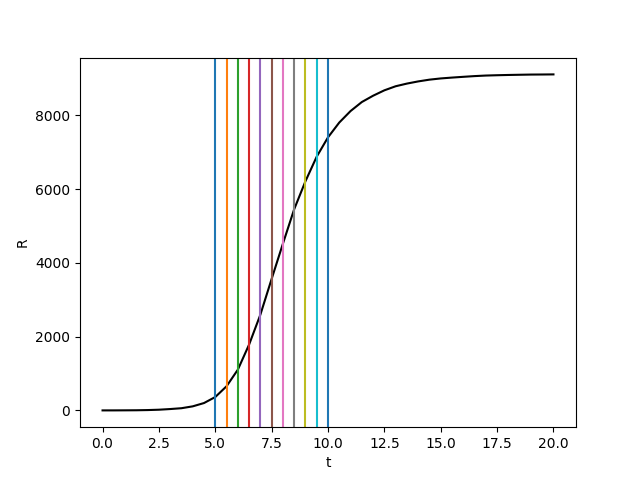

Text(0, 0.5, 'R')

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(tofsol, data_pd.flatten(), color='k')
for j in js:
    plt.axvline(tofsol[j], color=next(ax._get_lines.prop_cycler)['color'])
plt.xlabel("t")
plt.ylabel("R")

In [13]:
flat_data = data_pd.flatten()
def compare(sol):
    x = getx(sol['x'])[-1]
    return ca.sqrt(ca.sumsqr(ca.interp1d(model.observation_times, x, tofsol) - raw_data.flatten()))
    

<IPython.core.display.Javascript object>


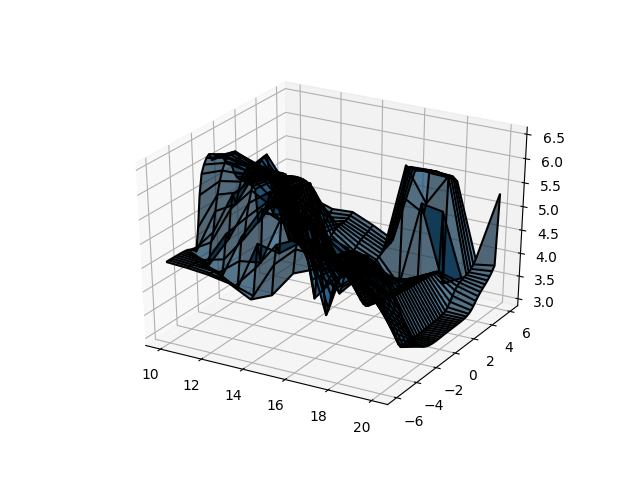

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x, y = np.meshgrid(js, np.log10(prange))

ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), alpha=0.7)
ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), color='k')

<IPython.core.display.Javascript object>


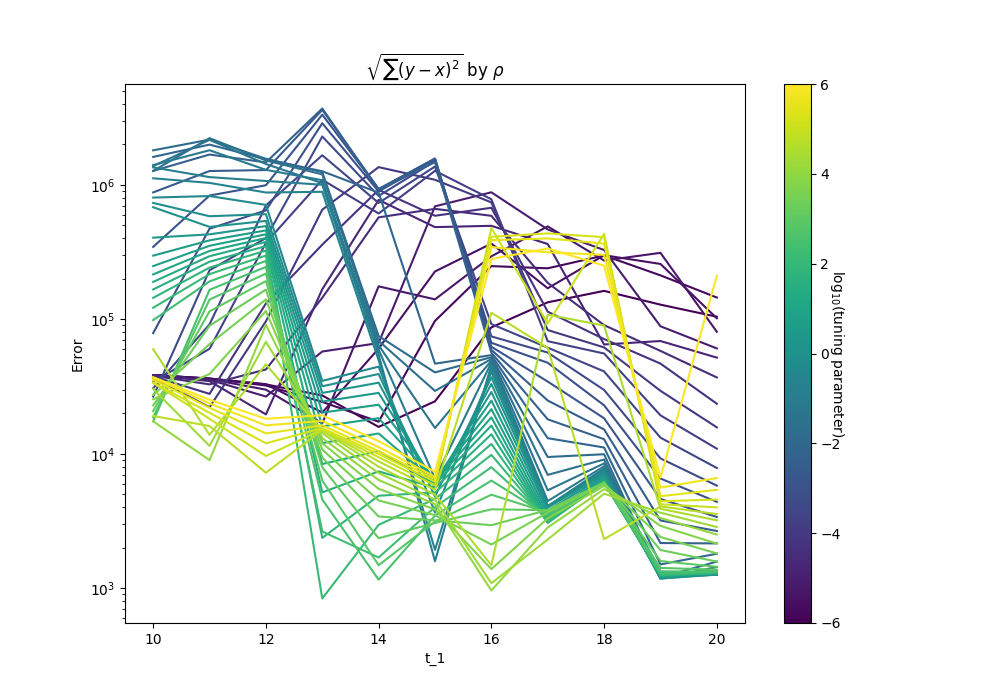

In [15]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[10,7])
for i,p in enumerate(prange):
    plt.semilogy(js, list(map(compare, [s[i] for s in fcv_vals])), color=scalarMap.to_rgba(np.log10(p)))
plt.title(r"$\sqrt{\sum (y-x)^2}$ by $\rho$")
plt.xlabel("t_1")
plt.ylabel("Error")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)


<IPython.core.display.Javascript object>


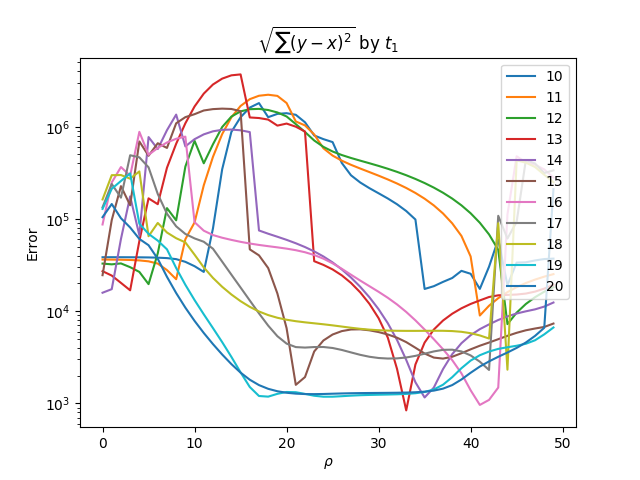

Text(0, 0.5, 'Error')

In [16]:
plt.figure()
for fcv_val in fcv_vals:
    plt.plot(list(map(compare, fcv_val)))
plt.yscale('log')
plt.legend(js)
plt.title(r"$\sqrt{\sum (y-x)^2}$ by $t_1$")
plt.xlabel(r"$\rho$")
plt.ylabel("Error")

<IPython.core.display.Javascript object>


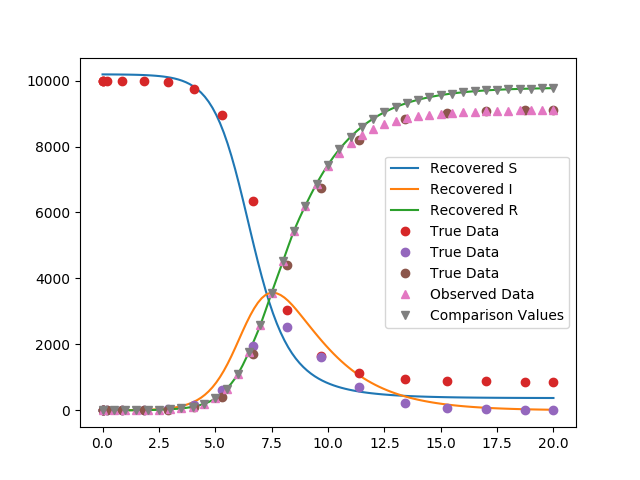

In [17]:
solx = getx(fcv_vals[-1][14]['x'])
plt.figure()
for lbl, xi in zip("SIR", solx):
    plt.plot(model.observation_times, xi, label="Recovered "+lbl)
plt.plot(sol.t, sol.y.T, 'o', label="True Data")
plt.plot(tofsol, data.T, '^', label="Observed Data")
plt.plot(tofsol, ca.interp1d(model.observation_times, solx[-1], tofsol), 'v', label="Comparison Values")
plt.legend(loc='best',)

In [18]:
def x1(sol):
    return np.abs(float(getx(sol['x'])[-1][-1]) - raw_data.flatten()[-1])

<IPython.core.display.Javascript object>


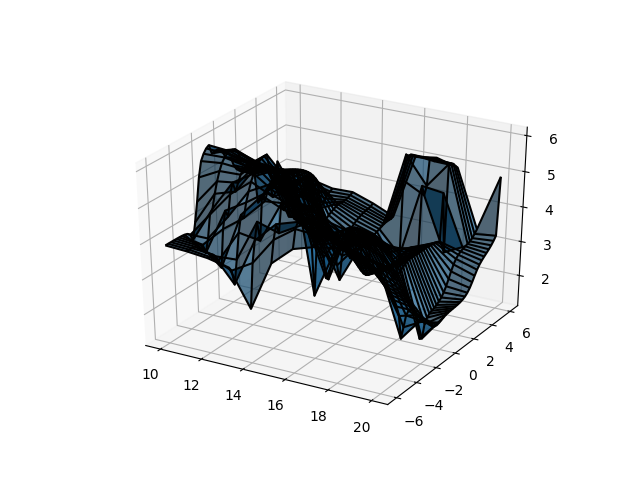

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x, y = np.meshgrid(js, np.log10(prange))

ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(x1, s)) for s in fcv_vals])), alpha=0.7)
ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(x1, s)) for s in fcv_vals])), color='k')

# ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), alpha=0.4)
# ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), color='k')

<IPython.core.display.Javascript object>


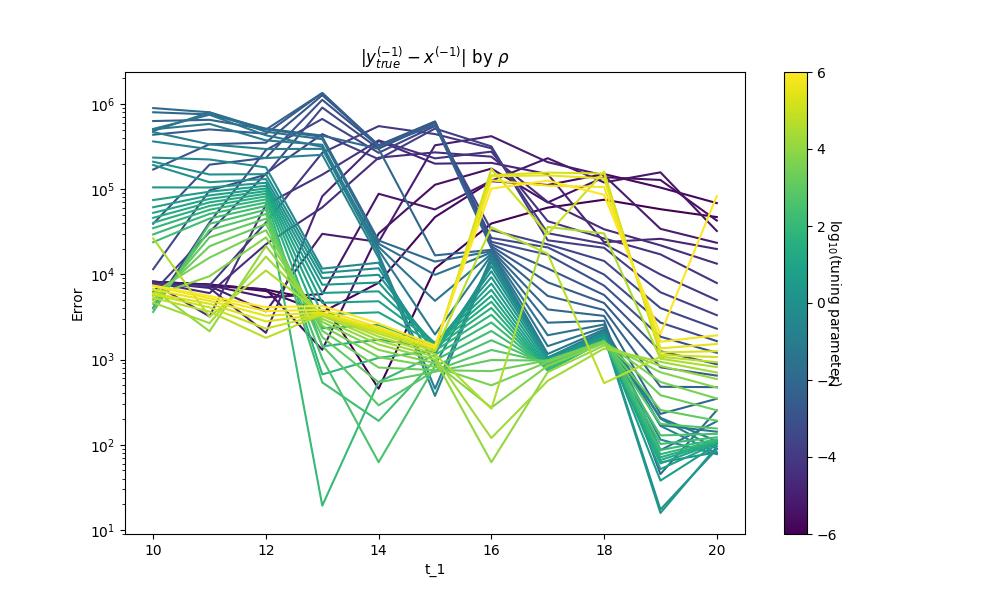

In [20]:
plt.figure(figsize=[10,6])
for i,p in enumerate(prange):
    plt.semilogy(js, list(map(x1, [s[i] for s in fcv_vals])), color=scalarMap.to_rgba(np.log10(p)))
plt.title(r"$|y^{(-1)}_{true}-x^{(-1)}|$ by $\rho$")
plt.xlabel("t_1")
plt.ylabel("Error")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)


<IPython.core.display.Javascript object>


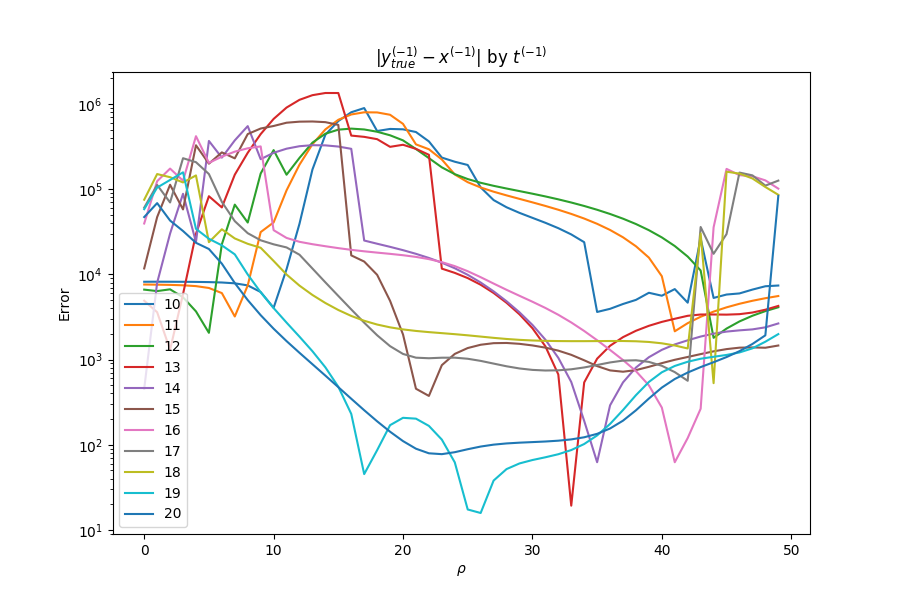

Text(0, 0.5, 'Error')

In [21]:
plt.figure(figsize=[9,6])
for fcv_val in fcv_vals:
    plt.plot(list(map(x1, fcv_val)))
plt.yscale('log')
plt.legend(js)
plt.title(r"$|y^{(-1)}_{true}-x^{(-1)}|$ by $t^{(-1)}$")
plt.xlabel(r"$\rho$")
plt.ylabel("Error")

In [22]:
terpx = [ca.interp1d(model.observation_times, sx, tofsol) for sx in solx]

In [23]:
ca.sumsqr(np.hstack(terpx).T - sol.sol(tofsol))

DM(3.04604e+07)

In [24]:
true_sol = sol.sol(tofsol)
def true_comp(sol):
    terpx = [ca.interp1d(model.observation_times, sx, tofsol) for sx in getx(sol['x'])]
    return ca.sumsqr(np.hstack(terpx).T - true_sol)

<IPython.core.display.Javascript object>


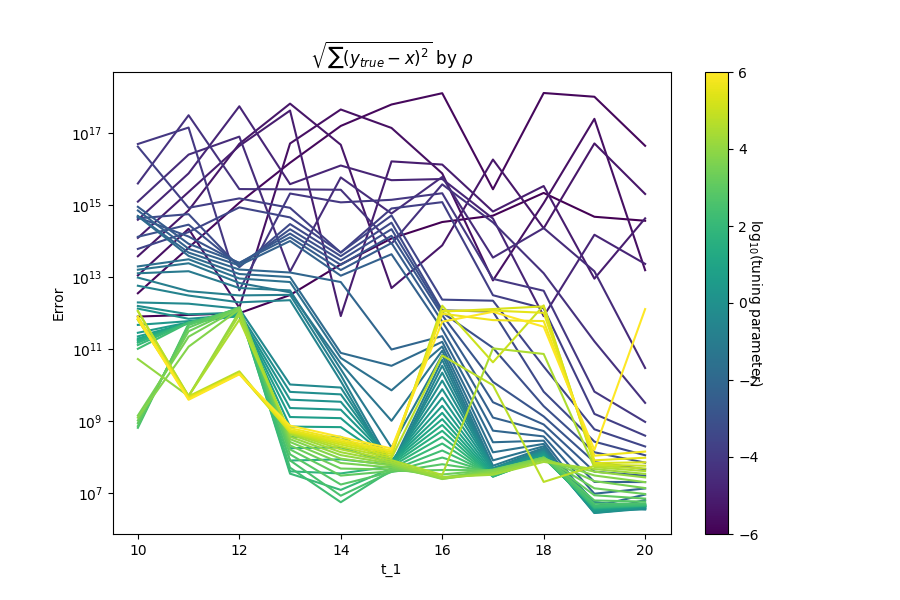

In [25]:
plt.figure(figsize=[9,6])
for i,p in enumerate(prange):
    plt.semilogy(js, list(map(true_comp, [s[i] for s in fcv_vals])), color=scalarMap.to_rgba(np.log10(p)))
plt.title(r"$\sqrt{\sum (y_{true}-x)^2}$ by $\rho$")
plt.xlabel("t_1")
plt.ylabel("Error")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)

<IPython.core.display.Javascript object>


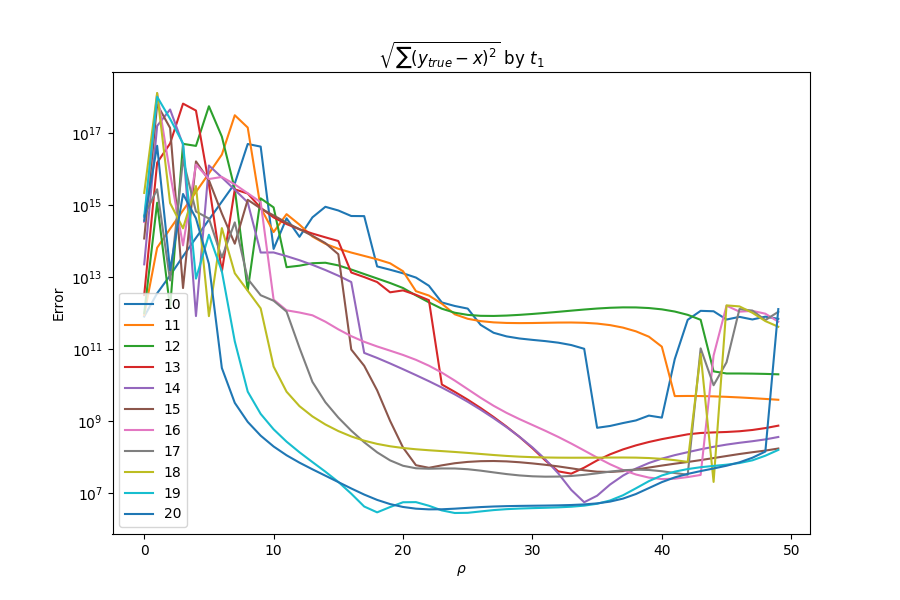

Text(0, 0.5, 'Error')

In [26]:
plt.figure(figsize=[9,6])
for fcv_val in fcv_vals:
    plt.plot(list(map(true_comp, fcv_val)))
plt.yscale('log')
plt.legend(js)
plt.title(r"$\sqrt{\sum (y_{true}-x)^2}$ by $t_1$")
plt.xlabel(r"$\rho$")
plt.ylabel("Error")

<IPython.core.display.Javascript object>


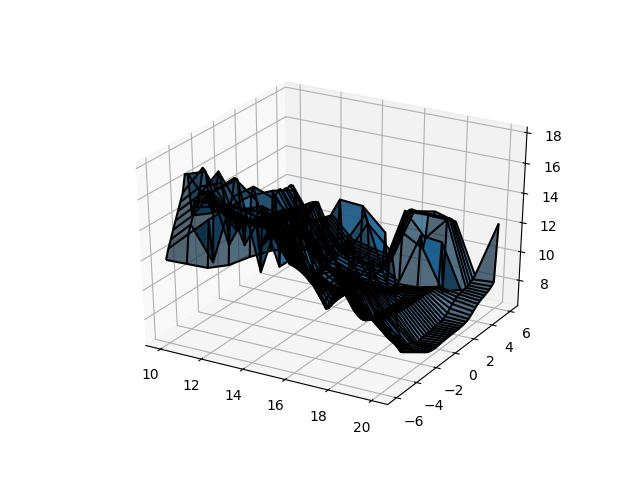

In [27]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x, y = np.meshgrid(js, np.log10(prange))

ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(true_comp, s)) for s in fcv_vals])), alpha=0.7)
ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(true_comp, s)) for s in fcv_vals])), color='k')

In [28]:
ldata = []
for (f1_ex, f2_ex), sols in zip(fsex, fcv_vals):
    ldata.append(np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols]))

<IPython.core.display.Javascript object>


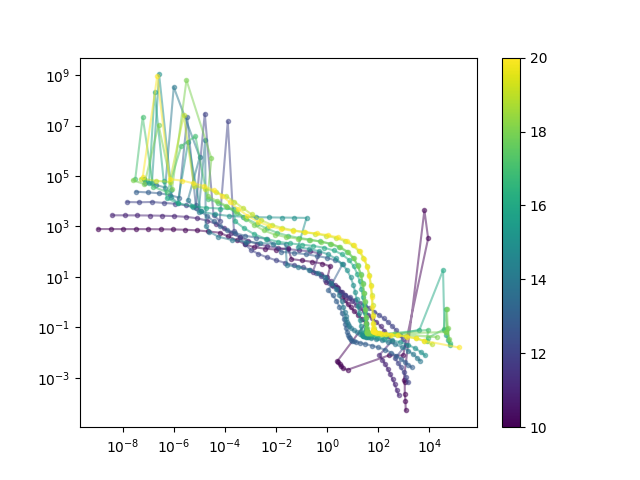

In [29]:
plt.figure()
cNormj = colors.Normalize(vmin=js[0], vmax=js[-1])
cm = plt.get_cmap('viridis')
scalarMapj = mplcm.ScalarMappable(norm=cNormj, cmap=cm)

for j,ld in zip(js,ldata):
    plt.loglog(*ld.T, '.-', color=scalarMapj.to_rgba(j), alpha=0.5)
plt.colorbar(scalarMapj)

<IPython.core.display.Javascript object>


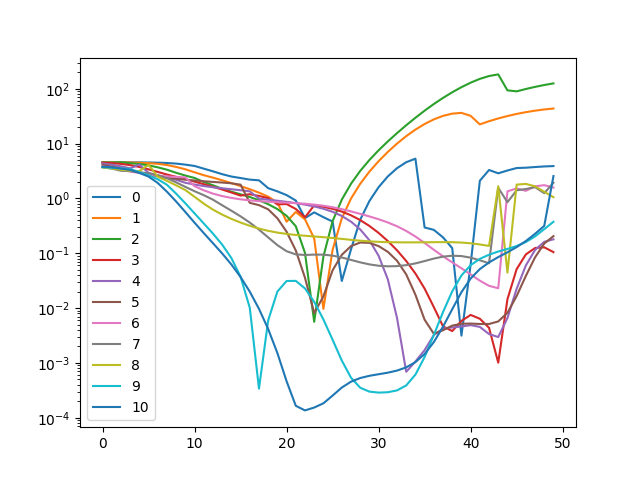

In [30]:
def comp_p(sol):
    return sum((getp(sol['x']) - np.array(p_true))**2)
plt.figure()
for i,fcv_val in enumerate(fcv_vals):
    plt.plot(list(map(comp_p, fcv_val)), label=str(i))
plt.yscale('log')
plt.legend()